In [1]:
!pip install -q osmnx geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.4/338.4 kB 13.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [2]:
#Import libraries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import numpy as np

# reproducible
np.random.seed(42)  

In [3]:
# Load from GeoPackage
gdf = gpd.read_file("/kaggle/input/kenya-map-data/kenya_admin.gpkg", layer="country")
counties = gpd.read_file("/kaggle/input/kenya-map-data/kenya_admin.gpkg", layer="counties")



In [25]:
# Load CSV of counties
counties_csv = pd.read_csv("/kaggle/input/kenya-census-data/kenya_census_data.csv")

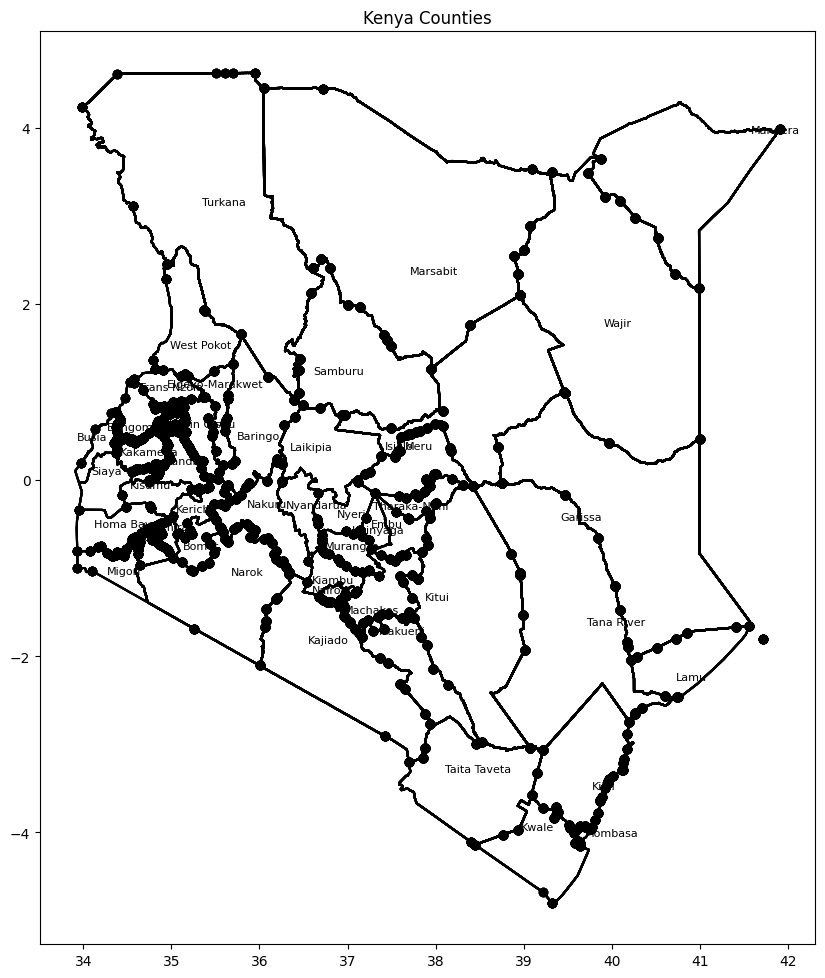

In [5]:
#Get Kenya polygon
kenya_poly = gdf.iloc[0].geometry

#add county boundaries (not sure if this is working right)
counties = gpd.clip(counties, kenya_poly)
# Plot counties
fig, ax = plt.subplots(figsize=(10, 12))
counties.boundary.plot(ax=ax, color="black")

# Overlay centroid labels from CSV
for _, row in counties_csv.iterrows():
    ax.text(row["Longitude"], row["Latitude"], row["County"], fontsize=8, ha="center")

ax.set_title("Kenya Counties")
plt.show()

In [6]:
# # get admin boundaries overlapping Kenya
# tags = {"boundary": "administrative"}
# gdf_admin = ox.features_from_polygon(kenya_poly, tags)

In [ ]:
# keep only counties (admin_level=4)
gdf_counties = gpd.read_file("/kaggle/input/kenya-map-data/kenya_admin_levels.geojson")

In [26]:
#gdf_admin[gdf_admin["admin_level"] == "4"].copy()

'''
1. Filter only Kenyan counties

Many Kenyan counties in OSM have an ISO3166-2 code like KE-xx.
So you can drop anything that doesn’t start with KE-.
'''
if "ISO3166-2" in gdf_counties.columns:
    gdf_counties = gdf_counties[gdf_counties["ISO3166-2"].str.startswith("KE-", na=False)]

# clean up labels

# Use name:en (English) if available, else fall back to name or official_name.

if "name:en" in gdf_counties.columns:
    gdf_counties["label"] = (
        gdf_counties["name:en"]
        .fillna(gdf_counties["name"])
        .fillna(gdf_counties["official_name"])
    )
else:
    gdf_counties["label"] = gdf_counties["name"]

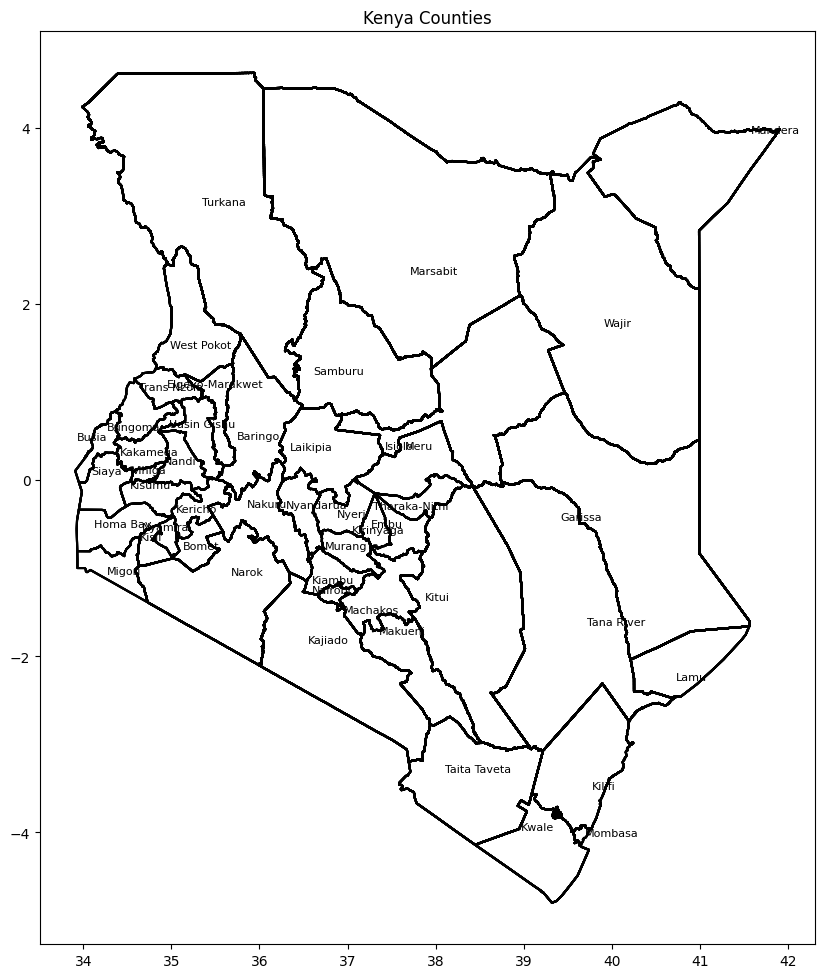

In [27]:
# Plot counties
fig, ax = plt.subplots(figsize=(10, 12))
gdf_counties.boundary.plot(ax=ax, color="black")

# Overlay centroid labels from CSV
for _, row in counties_csv.iterrows():
    ax.text(row["Longitude"], row["Latitude"], row["County"], fontsize=8, ha="center")

ax.set_title("Kenya Counties")
plt.show()

In [28]:
counties_csv['electrified_households'] = counties_csv['Conventional Households']*counties_csv['Mains Electricity']/100.0 

In [29]:
counties_csv['pop_per_household'] = counties_csv['TOTAL_POP']/counties_csv['Conventional Households'] 

In [30]:
# Ensure county names are clean on both sides
counties["name"] = counties["name"].str.strip().str.title()
counties_csv.drop(columns = ['geometry'],inplace=True)
# Merge CSV with OSMnx data
counties_merged = gdf_counties.merge(counties_csv, left_on="name", right_on="County", how="outer")

# Now counties_merged has both geometries + centroid info
#save counties merged.

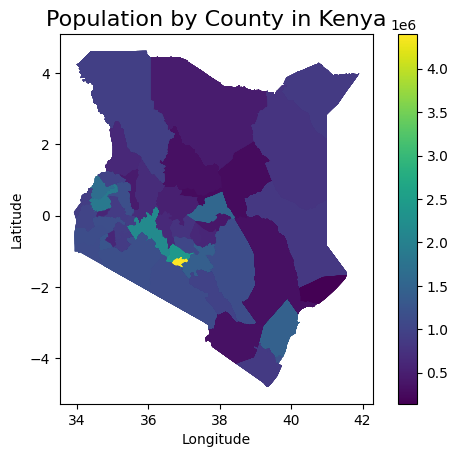

In [31]:
ax = counties_merged.plot(column="TOTAL_POP", legend=True)
plt.title("Population by County in Kenya", fontsize=16)
#plt.axis("off")  # optional, to hide axes
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

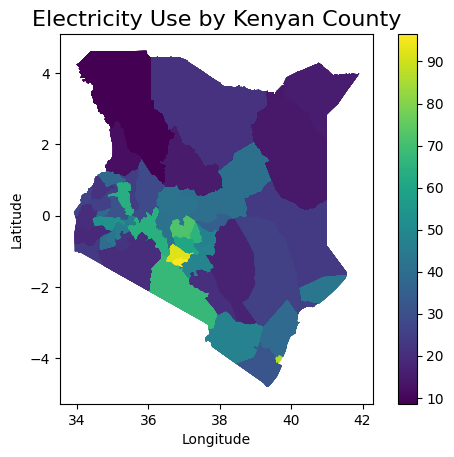

In [32]:
ax = counties_merged.plot(column="Mains Electricity", legend=True)
plt.title("Electricity Use by Kenyan County", fontsize=16)
#plt.axis("off")  # optional, to hide axes
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

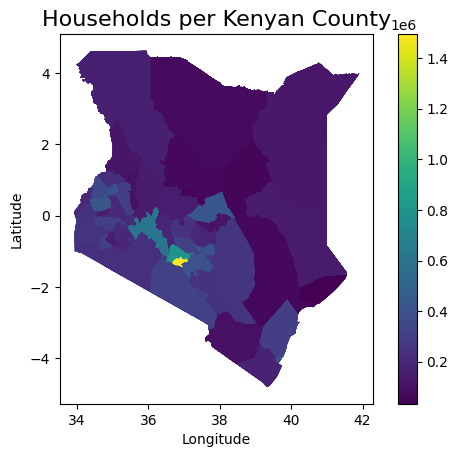

In [33]:
ax = counties_merged.plot(column="Conventional Households", legend=True)
plt.title("Households per Kenyan County", fontsize=16)
#plt.axis("off")  # optional, to hide axes
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

In [34]:
counties_merged[counties_merged['CODE']==1]

,element,id,admin_level,border_type,boundary,name,source,left:country,right:country,right:province,...,UNIT_PERIM,COUNT,COUNTY_NAM_y,TOTAL_POP,POP_DENSIT,ISO_Code,Latitude,Longitude,electrified_households,pop_per_household
291,relation,3495554,4,None,administrative,Mombasa,None,None,None,None,...,0.967209,34,Mombasa,1208333,517.354427,KE-28,-4.0435,40.0,323237.405,3.211132
292,relation,3495554,4,None,administrative,Mombasa,None,None,None,None,...,0.967209,34,Mombasa,1208333,517.354427,KE-28,-4.0435,40.0,323237.405,3.211132
293,relation,3495554,4,None,administrative,Mombasa,None,None,None,None,...,0.967209,34,Mombasa,1208333,517.354427,KE-28,-4.0435,40.0,323237.405,3.211132
294,relation,3495554,4,None,administrative,Mombasa,None,None,None,None,...,0.967209,34,Mombasa,1208333,517.354427,KE-28,-4.0435,40.0,323237.405,3.211132


In [35]:
counties_csv[counties_csv['CODE']==6]

,CODE,County,Conventional Households,Mains Electricity,UNIT_AREA,UNIT_PERIM,COUNT,COUNTY_NAM,TOTAL_POP,POP_DENSIT,ISO_Code,Latitude,Longitude,electrified_households,pop_per_household
5,6,Taita Taveta,94468,47.6,1.394121,5.835375,77,Taita Taveta,340671,2.443626,KE-39,-3.3167,38.4833,44966.768,3.606205


In [36]:
gdf_counties["name"].unique()

array(['Kisii', 'Narok', 'Homa Bay', 'Migori', 'Kajiado', 'Kisumu',
       'Nyamira', 'Busia', 'Vihiga', 'Machakos', 'Makueni', 'Nairobi',
       'Baringo', 'Bungoma', 'Embu', 'Garissa', 'Isiolo', 'Kiambu',
       'Kilifi', 'Kirinyaga', 'Kitui', 'Kwale', 'Laikipia', 'Lamu',
       'Marsabit', 'Meru', 'Mombasa', 'Nandi', 'Nyandarua', 'Nyeri',
       'Samburu', 'Taita Taveta', 'Tana River', 'Tharaka-Nithi',
       'Turkana', 'Uasin Gishu', 'Murang`a', 'West Pokot',
       'Elgeyo-Marakwet', 'Bomet', 'Nakuru', 'Kakamega', 'Siaya',
       'Mandera', 'Kericho', 'Wajir', 'Trans Nzoia'], dtype=object)

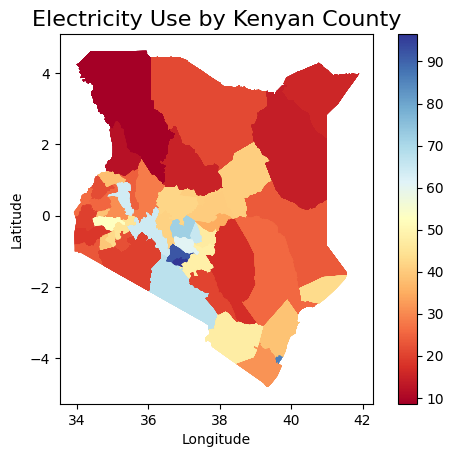

In [37]:
ax = counties_merged.plot(column="Mains Electricity", legend=True,cmap="RdYlBu")
plt.title("Electricity Use by Kenyan County", fontsize=16)
#plt.axis("off")  # optional, to hide axes
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

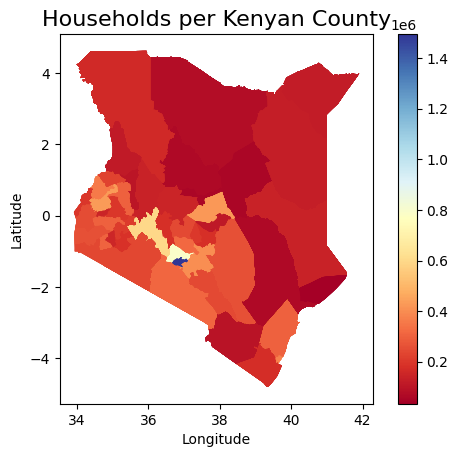

In [38]:
ax = counties_merged.plot(column="Conventional Households", legend=True,cmap="RdYlBu")
plt.title("Households per Kenyan County", fontsize=16)
#plt.axis("off")  # optional, to hide axes
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

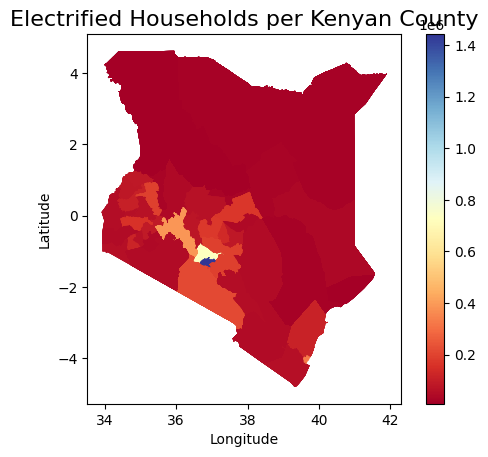

In [44]:
ax = counties_merged.plot(column="electrified_households", legend=True,cmap="RdYlBu")
plt.title("Electrified Households per Kenyan County", fontsize=16)
#plt.axis("off")  # optional, to hide axes
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

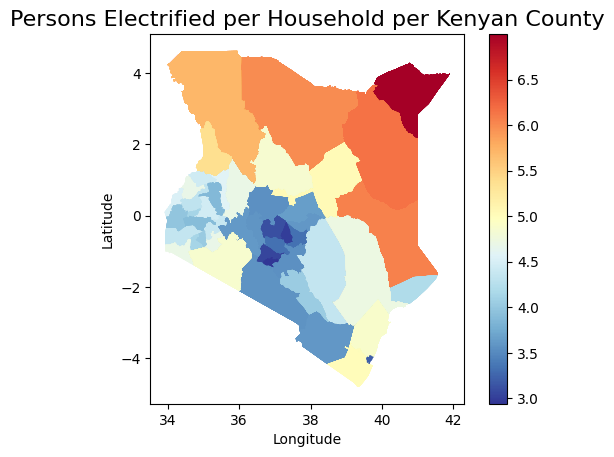

In [47]:
ax = counties_merged.plot(column="pop_per_household", legend=True,cmap="RdYlBu_r") #cmap="RdYlBu_r",   # reversed Red-Yellow-Blue

plt.title("Persons Electrified per Household per Kenyan County", fontsize=16)
#plt.axis("off")  # optional, to hide axes
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()